In [71]:
import json
from tensorflow.keras.models import load_model
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model

In [72]:


# Read the files word_to_idx.pkl and idx_to_word.pkl to get the mappings between word and index
word_to_index = {}
with open ("data/textFiles/word_to_idx.pkl", 'rb') as file:
    word_to_index = pd.read_pickle(file, compression=None)

index_to_word = {}
with open ("data/textFiles/idx_to_word.pkl", 'rb') as file:
    index_to_word = pd.read_pickle(file, compression=None)



print("Loading the model...")
model = load_model('model_checkpoints/model_14.h5')

resnet50_model = ResNet50 (weights = 'E:/模型/resnet50_weights_tf_dim_ordering_tf_kernels(1).h5', input_shape = (224, 224, 3))
resnet50_model = Model (resnet50_model.input, resnet50_model.layers[-2].output)

Loading the model...


In [73]:
# Generate Captions for a random image
# Using Greedy Search Algorithm

def predict_caption(photo):

    inp_text = "startseq"

    #max_len = 80 which is maximum length of caption
    for i in range(80):
        sequence = [word_to_index[w] for w in inp_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=80, padding='post')

        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = index_to_word[ypred]

        inp_text += (' ' + word)

        if word == 'endseq':
            break

    final_caption = inp_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [74]:
def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img


In [75]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)

    feature_vector = resnet50_model.predict(img)
    # feature_vector = feature_vector.reshape((-1,))
    return feature_vector


In [78]:
def runModel(img_name):
    #img_name = input("enter the image name to generate:\t")

#    print("Encoding the image ...")
    photo = encode_image(img_name).reshape((1, 2048))



#    print("Running model to generate the caption...")
    caption = predict_caption(photo)

#    img_data = plt.imread(img_name)
#    plt.imshow(img_data)
#    plt.axis("off")

    #plt.show()
#    print(caption)
    return caption

In [85]:
runModel('D:/data/flicker/flickr30k-images/flickr30k-images/14559446.jpg')

'a couple walking along a beach'

Encoding the image ...
Running model to generate the caption...
a man in a blue shirt is walking down the street


'a man in a blue shirt is walking down the street'

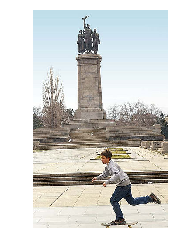

In [9]:
import cv2

runModel('D:/data/flicker/flickr30k-images/flickr30k-images/5230968.jpg')

Encoding the image ...
Running model to generate the caption...
a brown dog is running through a field


'a brown dog is running through a field'

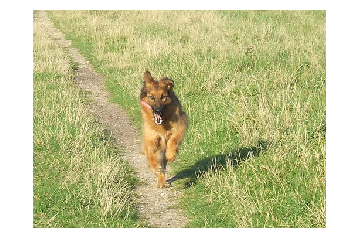

In [10]:
runModel('D:/data/flicker/Flickr8k and Flickr8kCN/Flicker8k_Dataset/240696675_7d05193aa0.jpg')

In [1]:
import matplotlib.pyplot as plt
import re
import cv2

In [2]:
def readFile (path):
    with open(path, encoding="utf8") as file:
        data = file.read()
    return data;

In [56]:
data = readFile ("data/textFiles/30k_captions.txt")

# Split the data into each line, to get a list of captions
captions = data.split('\n')
# Remove the last line since it is blank
captions = captions[:-1]

In [57]:
captions[-1]

'998845445.jpg#4\tA man on a moored blue and white boat with hills and mist in the background .'

In [6]:
print("Total number of caption = " + str(len(captions)))

Total number of caption = 158915


In [26]:
content = {}
references={}
for line in captions:
    imageID, caption = line.split('\t')

    imageID = imageID.split('.')[0]

    # If the imageID doesn't exist in the dictionary, create a blank entry
    if content.get(imageID) is None:
        content[imageID] = []
        references[imageID] = []

    # Append the current caption to the list of the corresponding image
    content[imageID].append(caption)
    references[imageID].append(caption.split())

In [46]:
#[references['1000092795']]
captions

['1000092795.jpg#0\tTwo young guys with shaggy hair look at their hands while hanging out in the yard .',
 '1000092795.jpg#1\tTwo young , White males are outside near many bushes .',
 '1000092795.jpg#2\tTwo men in green shirts are standing in a yard .',
 '1000092795.jpg#3\tA man in a blue shirt standing in a garden .',
 '1000092795.jpg#4\tTwo friends enjoy time spent together .',
 '10002456.jpg#0\tSeveral men in hard hats are operating a giant pulley system .',
 '10002456.jpg#1\tWorkers look down from up above on a piece of equipment .',
 '10002456.jpg#2\tTwo men working on a machine wearing hard hats .',
 '10002456.jpg#3\tFour men on top of a tall structure .',
 '10002456.jpg#4\tThree men on a large rig .',
 '1000268201.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201.jpg#1\tA little girl in a pink dress going into a wooden cabin .',
 '1000268201.jpg#2\tA little girl climbing the stairs to her playhouse .',
 '1000268201.jpg#3\tA little gir

In [64]:
data_val = readFile ("data/textFiles/flickr30k_val.txt")
imageID_val=[]
imageID_val = data_val.split('.jpg\n')
imageID_val=imageID_val[:-1]

In [66]:
imageID_val[-1]

'991459823'

In [68]:
from nltk.translate.bleu_score import corpus_bleu


generated_captions=['a man in a blue shirt is sitting on a lawn bench in a field'.split()]
scores=[]
for imageID in imageID_val:
    #print('BLEU-1 Score on test data: {:.3f}'.format(corpus_bleu([references[imageID]], generated_captions, weights=(1,0,0,0)) * 100))
    score=corpus_bleu([references[imageID]], generated_captions, weights=(1,0,0,0)) * 100
    print('BLEU-1 Score on test data: {:.3f}'.format(score))
    scores.append(score)



BLEU-1 Score on test data: 26.667
BLEU-1 Score on test data: 46.667
BLEU-1 Score on test data: 40.000
BLEU-1 Score on test data: 33.333
BLEU-1 Score on test data: 73.333
BLEU-1 Score on test data: 46.667
BLEU-1 Score on test data: 33.333
BLEU-1 Score on test data: 31.184
BLEU-1 Score on test data: 46.667
BLEU-1 Score on test data: 40.000
BLEU-1 Score on test data: 33.333
BLEU-1 Score on test data: 25.531
BLEU-1 Score on test data: 20.000
BLEU-1 Score on test data: 40.000
BLEU-1 Score on test data: 46.667
BLEU-1 Score on test data: 33.333
BLEU-1 Score on test data: 53.333
BLEU-1 Score on test data: 26.667
BLEU-1 Score on test data: 40.000
BLEU-1 Score on test data: 23.338
BLEU-1 Score on test data: 56.130
BLEU-1 Score on test data: 40.000
BLEU-1 Score on test data: 60.000
BLEU-1 Score on test data: 31.184
BLEU-1 Score on test data: 46.667
BLEU-1 Score on test data: 20.000
BLEU-1 Score on test data: 26.667
BLEU-1 Score on test data: 26.667
BLEU-1 Score on test data: 33.333
BLEU-1 Score o

BLEU-1 Score on test data: 40.841
BLEU-1 Score on test data: 53.333
BLEU-1 Score on test data: 33.333
BLEU-1 Score on test data: 26.667
BLEU-1 Score on test data: 46.667
BLEU-1 Score on test data: 33.333
BLEU-1 Score on test data: 26.667
BLEU-1 Score on test data: 46.667
BLEU-1 Score on test data: 31.184
BLEU-1 Score on test data: 56.130
BLEU-1 Score on test data: 60.000
BLEU-1 Score on test data: 46.676
BLEU-1 Score on test data: 20.000
BLEU-1 Score on test data: 53.333
BLEU-1 Score on test data: 66.667
BLEU-1 Score on test data: 13.333
BLEU-1 Score on test data: 66.667
BLEU-1 Score on test data: 33.333
BLEU-1 Score on test data: 18.710
BLEU-1 Score on test data: 40.000
BLEU-1 Score on test data: 53.333
BLEU-1 Score on test data: 20.000
BLEU-1 Score on test data: 20.000
BLEU-1 Score on test data: 53.333
BLEU-1 Score on test data: 13.333
BLEU-1 Score on test data: 43.657
BLEU-1 Score on test data: 29.172
BLEU-1 Score on test data: 35.007
BLEU-1 Score on test data: 20.000
BLEU-1 Score o

In [70]:
import numpy as np

np.mean(scores)

37.69166263903465

In [24]:
content[captions[0].split('.')[0]]

['Two young guys with shaggy hair look at their hands while hanging out in the yard .']

In [14]:
captions[5]

'10002456.jpg#0\tSeveral men in hard hats are operating a giant pulley system .'

In [17]:
content

{'1000092795': ['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
  'Two young , White males are outside near many bushes .',
  'Two men in green shirts are standing in a yard .',
  'A man in a blue shirt standing in a garden .',
  'Two friends enjoy time spent together .'],
 '10002456': ['Several men in hard hats are operating a giant pulley system .',
  'Workers look down from up above on a piece of equipment .',
  'Two men working on a machine wearing hard hats .',
  'Four men on top of a tall structure .',
  'Three men on a large rig .'],
 '1000268201': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A little girl in a pink dress going into a wooden cabin .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl climbing into a wooden playhouse .',
  'A girl going into a wooden building .'],
 '1000344755': ['Someone in a blue shirt and hat is standing on stair and leaning against a window .',


In [18]:
generate_captions=[]
for i in range(len(captions)):
    references=[]
    for j in range(5):
        k=i//5
        references.append(content[captions[i].split('.')[0]][j].split())
    


In [19]:
references

[['A',
  'man',
  'in',
  'shorts',
  'and',
  'a',
  'Hawaiian',
  'shirt',
  'leans',
  'over',
  'the',
  'rail',
  'of',
  'a',
  'pilot',
  'boat',
  ',',
  'with',
  'fog',
  'and',
  'mountains',
  'in',
  'the',
  'background',
  '.'],
 ['A',
  'young',
  'man',
  'hanging',
  'over',
  'the',
  'side',
  'of',
  'a',
  'boat',
  ',',
  'which',
  'is',
  'in',
  'a',
  'like',
  'with',
  'fog',
  'rolling',
  'over',
  'a',
  'hill',
  'behind',
  'it',
  '.'],
 ['A',
  'man',
  'is',
  'leaning',
  'off',
  'of',
  'the',
  'side',
  'of',
  'a',
  'blue',
  'and',
  'white',
  'boat',
  'as',
  'it',
  'sits',
  'in',
  'a',
  'body',
  'of',
  'water',
  '.'],
 ['A',
  'man',
  'riding',
  'a',
  'small',
  'boat',
  'in',
  'a',
  'harbor',
  ',',
  'with',
  'fog',
  'and',
  'mountains',
  'in',
  'the',
  'background',
  '.'],
 ['A',
  'man',
  'on',
  'a',
  'moored',
  'blue',
  'and',
  'white',
  'boat',
  'with',
  'hills',
  'and',
  'mist',
  'in',
  'the',
  'b

In [13]:
int(captions[0].split('.')[0])

1000092795

In [88]:
generated_captions=['a man in a blue shirt is sitting on a lawn bench in a field']

In [75]:
from nltk.translate.bleu_score import sentence_bleu

references=[]
for i in range(5):
    score=sentence_bleu(content[captions[0].split('.')[0]][i].split(), generated_captions, weights=(1,0,0,0)) * 100
    

In [79]:
score=sentence_bleu(content[captions[0].split('.')[0]][1].split(), generated_captions, weights=(1,0,0,0)) * 100
print(content[captions[0].split('.')[0]][1].split())
print(generated_captions)
print(score)

['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'sitting', 'on', 'a', 'lawn', 'bench', 'in', 'a', 'field']
6.666666666666667


In [86]:
references=[]
for j in range(5):
    references.append(content[captions[0].split('.')[0]][j].split())
references=[references]
print(references)

[[['Two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '.'], ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], ['Two', 'men', 'in', 'green', 'shirts', 'are', 'standing', 'in', 'a', 'yard', '.'], ['A', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'in', 'a', 'garden', '.'], ['Two', 'friends', 'enjoy', 'time', 'spent', 'together', '.']]]


In [90]:
from nltk.translate.bleu_score import corpus_bleu


references=[]
for j in range(5):
    references.append(content[captions[0].split('.')[0]][j].split())
references=[references]
generated_captions=['a man in a blue shirt is sitting on a lawn bench in a field'.split()]
print('BLEU-1 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(1,0,0,0)) * 100))

BLEU-1 Score on test data: 40.841
